<h1>Computer Vision: Number Plate Recognition (DPR)</h1>

Number Plate Recognition is an image-processing technology used to identify vehicles by their license plates. This technology is used in various security and traffic applications such as:
*   **Average-Speed Cameras:** DPR is used for speed limit enforcement. This works by tracking vehicles' travel time between two fixed points, and calculating the average speed.

*   **Crime Deterrent:** Recent innovations have contributed to the adoption of DPR for perimeter security and access control applications at government facilities.

*   **Traffic Control:** Many cities and districts have developed traffic control systems to help monitor the movement and flow of vehicles around the road network.

These are just some of the DPR usage, for more information please visit [Automatic number-plate recognition](https://en.wikipedia.org/wiki/Automatic_number-plate_recognition#Usage) on Wikipedia.


In this simpler task, we will classify three classes of normal number plate, defaced number plate and no number plate images. Also we use [Number Plate Recognition Contest](http://aaic.aut.ac.ir/leagues/sc/dpr)'s dataset which was held in [Amirkabir University of Technology](https://aut.ac.ir/en). This [dataset](https://drive.iust.ac.ir/index.php/s/IQOJTSRi6ToITIA) has three subdirectories which is briefly described as follow:
*   **0:** In this subdirectory, there are 1876 images of normal number plates, which have been taken with different size in different lighting. It should be noted that these number plates are available at different angles and are not necessarily located in the middle of the image.

*   **1:** In this subdirectory, there are 283 images of defaced number plates. The size of these images is different from each other like the previous class. In this class of images, part of the number plate (can be part of numbers or part of letters) is defaced by an object.

*   **2:** In this subdirectory, there are 568 images of no number plates class. Although no number plates can be found in these images, there may be part of the front of the car or text on a sign in the images.

In this task, we use 2183 of above dataset's image as train data and 544 of them as validation data.



## 1 - Importing Packages ##

First, let's run the cell below to import all the packages.
- [cv2](https://opencv.org/) is a library of programming functions mainly aimed at real-time computer vision.
- [imutils](https://pypi.org/project/imutils/) is a series of convenience functions to make basic image processing functions much more easier with OpenCV.
- [numpy](www.numpy.org) is the fundamental package for scientific computing with Python.
- [matplotlib](http://matplotlib.org) is a famous library to plot graphs in Python.
- [os](https://docs.python.org/3/library/os.html) module in python provides functions for interacting with the operating system.
- [keras](https://keras.io/) is an open-source neural-network library written in Python.
- [tensorflow](https://www.tensorflow.org/) is a Python library for fast numerical computing created and released by Google.

In [1]:
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import os

from keras.applications import InceptionResNetV2
from keras.applications.inception_resnet_v2 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import GlobalAveragePooling2D, Dense
from keras.callbacks import EarlyStopping

import tensorflow_addons as tfa
from tensorflow.keras.optimizers import Adam

## 2 - Declaring Constants and Parameters ##

Image Parameters:
- **IMG_WIDTH:** The width of resized dataset's image.
- **IMG_HEIGHT:** The height of resized dataset's image.

Model parameters:
- **EPOCHS:** Number of epochs we want to train our model for.

General Parameters:
- **N_CLASSES:** The number of classes used in dataset.

In [2]:
# Image Parameters:
IMG_WIDTH, IMG_HEIGHT = 620, 480

# Model Parameters:
EPOCHS = 10
BATCH_SIZE= 10

# Pre-Process Parameters:
STRUCTURING_ELEMENT_1 = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 20))
STRUCTURING_ELEMENT_2 = cv2.getStructuringElement(cv2.MORPH_RECT, (60, 1))
STRUCTURING_ELEMENT_3 = cv2.getStructuringElement(cv2.MORPH_RECT, (20, 1))
STRUCTURING_ELEMENT_4 = cv2.getStructuringElement(cv2.MORPH_RECT, (30, 30))
STRUCTURING_ELEMENT_5 = cv2.getStructuringElement(cv2.MORPH_RECT, (150, 5))

# General Parameters:
N_CLASSES = 3

## 3 - Loading Data ##

I provide data from my drive which I uploaded before.
*   [Dataset.zip](https://drive.google.com/drive/folders/1x6_PuUoB5LQ07IJk_BTSVugbMAeLn6u5?usp=sharing)
*   [Dataset](https://drive.google.com/file/d/1jBWSOLNo-dwIRjuBj7AcyJWJQHVbFP0M/view?usp=sharing)

Also you can download these datasets from links above.

In [3]:
# Download Dataset.zip from drive.
!gdown --id "1jBWSOLNo-dwIRjuBj7AcyJWJQHVbFP0M"

Downloading...
From: https://drive.google.com/uc?id=1jBWSOLNo-dwIRjuBj7AcyJWJQHVbFP0M
To: /content/Dataset.zip
63.3MB [00:00, 88.1MB/s]


In [4]:
# Unzip Dataset.zip.
!unzip Dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Dataset/0/0926.jpg      
  inflating: __MACOSX/Dataset/0/._0926.jpg  
  inflating: Dataset/0/1437.jpg      
  inflating: __MACOSX/Dataset/0/._1437.jpg  
  inflating: Dataset/0/0729.jpg      
  inflating: __MACOSX/Dataset/0/._0729.jpg  
  inflating: Dataset/0/1351.jpg      
  inflating: __MACOSX/Dataset/0/._1351.jpg  
  inflating: Dataset/0/1345.jpg      
  inflating: __MACOSX/Dataset/0/._1345.jpg  
  inflating: Dataset/0/1423.jpg      
  inflating: __MACOSX/Dataset/0/._1423.jpg  
  inflating: Dataset/0/0715.jpg      
  inflating: __MACOSX/Dataset/0/._0715.jpg  
  inflating: Dataset/0/0073.jpg      
  inflating: __MACOSX/Dataset/0/._0073.jpg  
  inflating: Dataset/0/0067.jpg      
  inflating: __MACOSX/Dataset/0/._0067.jpg  
  inflating: Dataset/0/1379.jpg      
  inflating: __MACOSX/Dataset/0/._1379.jpg  
  inflating: Dataset/0/0701.jpg      
  inflating: __MACOSX/Dataset/0/._0701.jpg  
  inflating: Dataset/0/0739.jpg     

## 4 - Visualizing Data ##

In this section, some of the images from each class are randomly displayed:

/content/Dataset/0


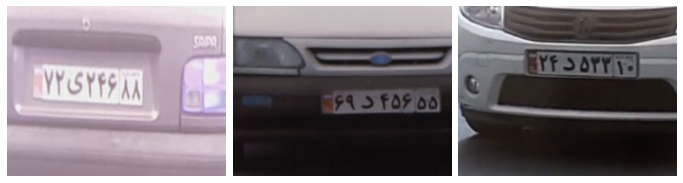

/content/Dataset/1


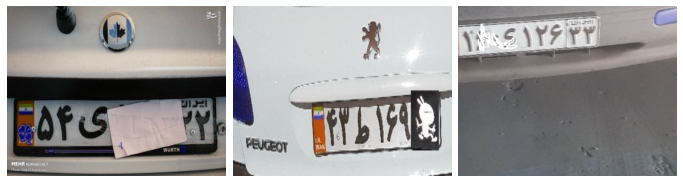

/content/Dataset/2


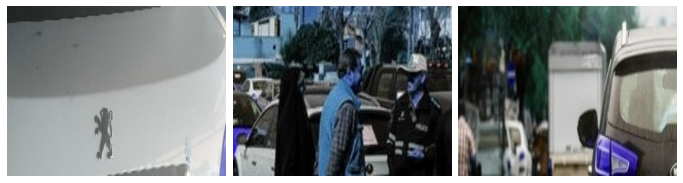

In [5]:
def show_samples():
  # The name of all images in current directory.
  sample_names = [name for name in os.listdir('.') if os.path.isfile(name)]

  # Choose 3 random images from current directory.
  rand_3 = np.random.randint(0, len(sample_names), 3)

  # Read and resize random images.
  sample_images = [cv2.resize(cv2.imread(file_name), (IMG_WIDTH, IMG_HEIGHT)) for file_name in [sample_names[i] for i in rand_3]]

  num_cols = 3     # Number of columns in plot.
  # Create desired plot.
  f, ax = plt.subplots(1, num_cols, figsize=(12,5),
                      gridspec_kw={'wspace':0.03, 'hspace':0.01}, 
                      squeeze=True)

  # Fill the plot with random images.
  for c in range(num_cols):
      ax[c].axis("off")
      ax[c].imshow(sample_images[c])
  plt.show()
  plt.close()

%cd /content/Dataset/0
show_samples()                 # Plot random images from set 0.
%cd ../1
show_samples()                 # Plot random images from set 1.
%cd ../2
show_samples()                 # Plot random images from set 2.


## 5 - Image Pre-Processing ##

In this section, the necessary operations are performed before the training process:

First of all, we find the region of intrests (ROI) of image:


In [6]:
def find_ROI(img):
    # Change the type of image to uint8 for further operations.
    img = img.astype(np.uint8)

    # Convert the RGB image to gray scale image.
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Blur the image with Gaussian filter.
    blurred_image = cv2.GaussianBlur(gray, (5, 5), 0)

    # A bilateral filter is a non-linear, edge-preserving, and noise-reducing smoothing filter for images.
    bilateral_image = cv2.bilateralFilter(blurred_image, 13, 15, 15)

    # Apply adaptive threshold to image to obtain a binary image.
    adther = cv2.adaptiveThreshold(bilateral_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 21, 2)

    # Find edges of image by Canny technique.
    canny = cv2.Canny(adther, 10, 240)

    # Thicken the lines found.
    lines = cv2.HoughLinesP(canny, 1, np.pi/180, 1)
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(canny, (x1, y1), (x2, y2), (255, 255, 255), 3)

    # Apply openning operation with long vertical line.
    #       ---> Only long vertical lines remain in image.
    openningV = cv2.morphologyEx(canny.copy(), cv2.MORPH_OPEN, STRUCTURING_ELEMENT_1)

    # Padding the image with black color.
    openningV = cv2.copyMakeBorder(openningV, 200, 200, 200, 200, cv2.BORDER_CONSTANT, 0)

    # Apply closing operation with long horizontal line.
    #       ---> Connect number plate components to each other.
    closeH = cv2.morphologyEx(openningV, cv2.MORPH_CLOSE, STRUCTURING_ELEMENT_2)

    # Apply openning operation with long horizontal line.
    #       ---> Remove non number plate components.
    openH = cv2.morphologyEx(closeH, cv2.MORPH_OPEN, STRUCTURING_ELEMENT_3)

    # Apply dilate operation with square element.
    #       ---> Connect number plate components to each other again.
    dilate = cv2.dilate(openH, STRUCTURING_ELEMENT_4)

    # Apply closing operation with long horizontal line.
    #       ---> Connect number plate components to each other in the case of...
    #            letter not be recognized.
    closeHAgain = cv2.morphologyEx(dilate, cv2.MORPH_CLOSE, STRUCTURING_ELEMENT_5)

    # Remove padding.
    closeHAgain = closeHAgain[200:-200, 200:-200]
    
    return closeHAgain

Then we mask original image with ROI image to obtain number plate.

In [7]:
def find_condidate_number_plate(img):
    # Resize the image.
    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))

    # Find region of interest (ROI) of image.
    ROIs = find_ROI(img)

    # Mask the original image with ROI image.
    number_plate = cv2.bitwise_and(img, img, mask=ROIs)
    return number_plate

Finally, we gather two above functions as following function:

In [8]:
def my_preprocessing_function(img):
    # Find condidate number plate.
    new_image = find_condidate_number_plate(img)

    # Change the type of image to float32 for further operations.
    new_image = new_image.astype(np.float32)
    
    # Perform InceptionResnetV2 pre-process before training.
    final_image = preprocess_input(new_image)

    return final_image

## 6 - Importing and Augmenting Data ##

In this section, we we import and augment data from dataset folder by following functions:


In [9]:
# Split and augment data with following properties.
train_datagen_aug = ImageDataGenerator(rotation_range=20, shear_range=0.1, zoom_range=0.1,
                                       horizontal_flip=True,
                                       preprocessing_function=my_preprocessing_function,
                                       validation_split=0.2)

In [10]:
# Import training data.
train_generator_aug = train_datagen_aug.flow_from_directory('/content/Dataset', target_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=BATCH_SIZE, shuffle=True, subset='training')

# Import validation data.
validation_generator_aug = train_datagen_aug.flow_from_directory('/content/Dataset', target_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=BATCH_SIZE, shuffle=True, subset='validation')

Found 2183 images belonging to 3 classes.
Found 544 images belonging to 3 classes.


## 7 - Building Model ##

In this section, we build our modified model for this task.


In [11]:
def build_model_with_InceptionResNetV2():
    # Create InceptionResNetV2 model with imagenet weights.
    model = InceptionResNetV2(include_top=False, weights='imagenet', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

    # Make all layers trainable.
    for layer in model.layers:
        layer.trainable = True

    # Add avgPooling layer to reduce parameters and flatten the output.
    avgPooling = GlobalAveragePooling2D()(model.output)

    # Add two dense layers for classification.
    dense1 = Dense(1024, activation='relu')(avgPooling)
    dense2 = Dense(N_CLASSES, activation='softmax')(dense1)

    # Create final model.
    model = Model(model.input, dense2)
    
    return model

## 8 - Training Model ##

In this section, we train our modified model for this task and report its progress every epoch.


In [12]:
# Build model.
model = build_model_with_InceptionResNetV2()

# Create a F1 metric for training reports.
F1_metric = tfa.metrics.F1Score(num_classes=3, average="macro")

# Compile model.
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4), metrics=['accuracy', F1_metric])

# Create early stopping to restore best weights by monitoring accuracy of validation data.
early_stopping = EarlyStopping(monitor='val_accuracy', patience=EPOCHS, restore_best_weights=True)

# Train the model.
model.fit(train_generator_aug, validation_data=validation_generator_aug, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[early_stopping])

219062272/219055592 [==============================] - 2s 0us/step
Epoch 1/10
219/219 [==============================] - 545s 2s/step - loss: 0.5904 - accuracy: 0.7702 - f1_score: 0.5454 - val_loss: 0.3957 - val_accuracy: 0.8088 - val_f1_score: 0.7648
Epoch 2/10
219/219 [==============================] - 514s 2s/step - loss: 0.3090 - accuracy: 0.8702 - f1_score: 0.7611 - val_loss: 0.2306 - val_accuracy: 0.9301 - val_f1_score: 0.8612
Epoch 3/10
219/219 [==============================] - 512s 2s/step - loss: 0.1767 - accuracy: 0.9325 - f1_score: 0.8746 - val_loss: 0.1910 - val_accuracy: 0.9393 - val_f1_score: 0.8748
Epoch 4/10
219/219 [==============================] - 512s 2s/step - loss: 0.1412 - accuracy: 0.9504 - f1_score: 0.9037 - val_loss: 0.2091 - val_accuracy: 0.9430 - val_f1_score: 0.9071
Epoch 5/10
219/219 [==============================] - 513s 2s/step - loss: 0.1070 - accuracy: 0.9680 - f1_score: 0.9371 - val_loss: 0.1542 - val_accuracy: 0.9540 - val_f1_score: 0.9135
Epoch 6/

## 9 - Save Model ##

In this section, we save our modified model for this task in google drive.


In [13]:
from google.colab import drive

# Mount drive.
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [15]:
# Change directory to desire location.
%cd /content/gdrive/MyDrive/ComputerVision/FinalProject/Final/NoShift

/content/gdrive/MyDrive/ComputerVision/FinalProject/Final/NoShift


In [16]:
# Save model.
model.save('InceptionResNetV2_10.h5')